In [2]:
# Incase Of Update
response = requests.get('https://db.ygoprodeck.com/api/v7/cardinfo.php')
json_response = response.json()
dataset = pd.DataFrame(json_response['data'])

dataset.to_csv('Dataset/Yugioh_Database.csv')

In [254]:
import requests
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
import itertools
import random as random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

warnings.simplefilter(action='ignore', category=FutureWarning)
plt.style.use('Solarize_Light2')
pd.set_option('display.max_columns', 20)


In [246]:
''' Deck Based DataSet'''


file = open('Dataset/Deck_Lists.txt' , 'r')
read = file.readlines()
altered = []
flag = False

temp=[]

for count,line in enumerate(read):
    
    if '//' in read[count]:
        flag = not flag
    
    
    if flag:
        
        read[count] = read[count].replace('\n','')
        
        if ('=='  in read[count]) or ('//'  in read[count])  :
            pass
            
        else:
           for i in range(int(read[count][0])):
              temp.append(read[count][1:].strip())          #skip appending also remove white space

  

    if (not flag) or (count == len(read) - 1):
        altered.append(temp)
        temp = []
        flag = not flag
        
        
        
file.close()    
            
            


    
    
xp = [random.choice(altered[1]) for _ in range(10)]
print(xp)   
dataset[dataset['name'].isin( xp  )  ]['desc']   # Might skip printing a value because it was chosen twice


['Knightmare Unicorn', 'Floowandereeze and the Advent of Adventure', 'Pot of Extravagance', 'Tearlaments Kaleido-Heart', 'Underworld Goddess of the Closed World', 'Tearlaments Kitkallos', 'Crossout Designator', 'Tearlaments Kaleido-Heart', 'Dimension Shifter', 'Swordsoul Supreme Sovereign - Chengying']


2066     Declare 1 card name; banish 1 of that declared...
2904     If you have no cards in your GY (Quick Effect)...
4126     Banish 1 Winged Beast monster from your hand o...
6122     2+ monsters with different names\r\nIf this ca...
8651     At the start of your Main Phase 1: Banish 3 or...
10942    1 Tuner + 1+ non-Tuner monsters\r\nFor each ba...
11081    "Tearlaments Reinoheart" + 2 Aqua monsters\r\n...
11083    1 "Tearlaments" monster + 1 Aqua monster\r\nIf...
11967    4+ Effect Monsters\r\nYou can also use 1 monst...
Name: desc, dtype: object

In [247]:
# Load Dataset
dataset = pd.read_csv('Dataset/Yugioh_Database.csv')
dataset = dataset.drop(['Unnamed: 0' , 'frameType' , 'archetype' , 'ygoprodeck_url' , 'card_sets' , 'card_images' , 'card_prices' , 'banlist_info'],axis=1)
dataset = dataset[dataset['type'] != 'XYZ Pendulum Effect Monster']
dataset = dataset[dataset['type'] != 'Synchro Pendulum Effect Monster']
dataset = dataset[dataset['type'] != 'Fusion Pendulum Effect Monster']
dataset = dataset[dataset['type'] != 'Pendulum Effect Monster']
dataset = dataset[dataset['type'] != 'Pendulum Normal Monster']

dataset = dataset[dataset['type'] != 'Skill Card']
dataset = dataset[dataset['type'] != 'Monster Token']

dataset.loc[dataset['type']=='Normal Monster', ['desc']] = 'NoInfo'
dataset = dataset.fillna('0')
dataset['level'] = dataset['level'].astype('int32')

#dataset[dataset['id'] == 65518099]


df = dataset['desc']         #Tokenizer is only trained on desc and based on that 
Sliced_df = dataset[['level' , 'race' , 'type' , 'attribute' , 'name' , 'desc']]

for i in range(1,11,2):
    Sliced_df.insert(loc=i, column='A'+str(i), value=-1)
    

tokenizer = Tokenizer(filters='\r , \n , \" ') # Speech marks stop names from being recognised by tokenizer
tokenizer.fit_on_texts(df)
tokenizer.word_index['0'] = 0           #Signifies Empty values
tokenizer.word_index['-1'] = -1           #Signifies Seperators





In [248]:
Sliced_df

,level,A1,race,A3,type,A5,attribute,A7,name,A9,desc
0,0,-1,Continuous,-1,Spell Card,-1,0,-1,"""A"" Cell Breeding Device",-1,"During each of your Standby Phases, put 1 A-Co..."
1,0,-1,Continuous,-1,Spell Card,-1,0,-1,"""A"" Cell Incubator",-1,Each time an A-Counter(s) is removed from play...
2,0,-1,Quick-Play,-1,Spell Card,-1,0,-1,"""A"" Cell Recombination Device",-1,Target 1 face-up monster on the field; send 1 ...
3,0,-1,Quick-Play,-1,Spell Card,-1,0,-1,"""A"" Cell Scatter Burst",-1,"Select 1 face-up ""Alien"" monster you control. ..."
4,0,-1,Equip,-1,Spell Card,-1,0,-1,"""Infernoble Arms - Almace""",-1,While this card is equipped to a monster: You ...
...,...,...,...,...,...,...,...,...,...,...,...
12931,4,-1,Beast,-1,Effect Monster,-1,LIGHT,-1,ZW - Sleipnir Mail,-1,"You can target 1 ""Utopia"" monster you control;..."
12932,4,-1,Beast,-1,Effect Monster,-1,LIGHT,-1,ZW - Sylphid Wing,-1,"You can only control 1 ""ZW - Sylphid Wing"". Yo..."
12933,5,-1,Dragon,-1,Effect Monster,-1,WIND,-1,ZW - Tornado Bringer,-1,"You can target 1 ""Utopia"" monster you control;..."
12934,4,-1,Aqua,-1,Effect Monster,-1,EARTH,-1,ZW - Ultimate Shield,-1,When this card is Normal or Special Summoned: ...


In [255]:
sequences = []
padded_sequences = []
count = 0
for i in Sliced_df.astype('string').to_numpy():
    
    sequences.append(tokenizer.texts_to_sequences(i))
     
#pd.DataFrame(np.array(sequences)[:,6])[0:10] # now i got the columns i need to padd each one of them and recreate dataframe
for i in range(0,11):
    padded_sequences.append( pad_sequences(np.array(sequences)[:,i], padding='post') ) ##this

pd.DataFrame(np.concatenate(([padded_sequences[i] for i in range(11)]) , axis=1 ))[0:20]
    
 

C:\Users\X99S5\AppData\Local\Temp\ipykernel_14252\4249120965.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  padded_sequences.append( pad_sequences(np.array(sequences)[:,i], padding='post') ) ##this


,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,180
0,0,-1,329,0,-1,80,5,0,0,-1,...,0,0,0,0,0,0,0,0,0,0
1,0,-1,329,0,-1,80,5,0,0,-1,...,0,0,0,0,0,0,0,0,0,0
2,0,-1,703,0,-1,80,5,0,0,-1,...,0,0,0,0,0,0,0,0,0,0
3,0,-1,703,0,-1,80,5,0,0,-1,...,0,0,0,0,0,0,0,0,0,0
4,0,-1,113,0,-1,80,5,0,0,-1,...,0,0,0,0,0,0,0,0,0,0
5,0,-1,113,0,-1,80,5,0,0,-1,...,0,0,0,0,0,0,0,0,0,0
6,0,-1,113,0,-1,80,5,0,0,-1,...,0,0,0,0,0,0,0,0,0,0
7,0,-1,113,0,-1,80,5,0,0,-1,...,0,0,0,0,0,0,0,0,0,0
8,0,-1,59,0,-1,80,5,0,0,-1,...,0,0,0,0,0,0,0,0,0,0
9,97,-1,147,0,-1,21,8,0,0,-1,...,0,0,0,0,0,0,0,0,0,0


In [252]:
#dataset[['level' , 'race' , 'type' , 'attribute' , 'name' , 'desc']]
tokenizer.sequences_to_texts([[  0,  -1,  59,   0,  -1, 112,   5,   0,   0,  -1,   0,  -1,  17,
       213,   0,   0,   0,   0,   0,   0,   0,  -1,  37,  51,  43,   8,
       238,  51, 241,   3,  33, 669,   7, 404,   5,  11,   3,  35,  53,
        12,  29,  13,  17,   8,  25,   6,  42,  14,  49,  14,  16, 103,
       479,  77,  29,   9,   2, 145,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

["normal trap card a hero when an opponent's monster declares an attack: your opponent chooses 1 random card from your hand then if it is a monster that can be special summoned special summon it. otherwise send it to the graveyard."]

In [86]:

class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x
  
class Encoder(tf.keras.Model):

  def __init__(self , num_layers):
    super().__init__()

    self.num_layers = num_layers
    

    self.seq = [ GlobalSelfAttention(num_heads=4, key_dim=100) for _ in range(self.num_layers)  ]       # Scaling Number of Heads increases parameters as this is a different implementation of mha compared to attention is all you need paper.
    

  def call(self, inputs, training=None, mask=None):
    
    x = inputs
    
    
    for i in range(self.num_layers):
      #print(x)
      x = self.seq[i](x)

    return x

En = Encoder(3)
En(output_array[0:1])
En.summary() 


Model: "encoder_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_self_attention_167 (  multiple                 161500    
 GlobalSelfAttention)                                            
                                                                 
 global_self_attention_168 (  multiple                 161500    
 GlobalSelfAttention)                                            
                                                                 
 global_self_attention_169 (  multiple                 161500    
 GlobalSelfAttention)                                            
                                                                 
Total params: 484,500
Trainable params: 484,500
Non-trainable params: 0
_________________________________________________________________


In [98]:

def Positional_Encoder(length , depth):
      '''Positional Encoder'''
      
      
      depth = depth/2

      positions = np.arange(length)[:, np.newaxis] # of the sentance
      depths = np.arange(depth)[np.newaxis, :]/depth



      angle_rates = 1 / (10000**depths)
      angle_rads = positions * angle_rates



      pos_encoding = np.concatenate(
            [np.sin(angle_rads), np.cos(angle_rads)],
            axis=-1)
      
      return tf.cast(pos_encoding, dtype=tf.float32)

 

In [58]:
class p():
    def __init__(self, x):
        print(x+1)

class wth(p):
    def call(self):
        print("hello")

hgf = wth(4)
hgf()

5


TypeError: 'wth' object is not callable

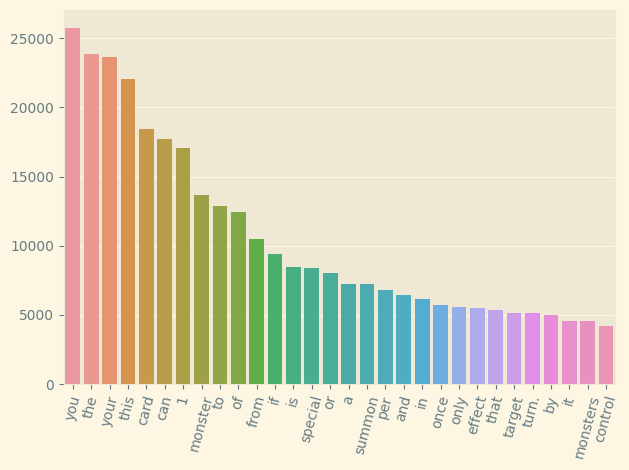

In [58]:
''' Token Frequencies '''
my_dict = tokenizer.word_counts
my_dict = {k: v for k, v in sorted(my_dict.items(), key=lambda item: item[1] , reverse=True,)}
my_dict = dict(itertools.islice(my_dict.items(), 30))

keys = list(my_dict.keys())
vals = [float(my_dict[k]) for k in keys]

sns.barplot(x=keys, y=vals)
plt.xticks(rotation=75)
plt.tight_layout()

#======================================
q = np.array([[2,2],[4,1]])
k = np.array([[1,2],[4,5]])


a = np.array([[1,1],[1,1]])

np.dot(a,q)
#np.matmul(q,a)
#======================================


array([[4, 5],
       [4, 5]])

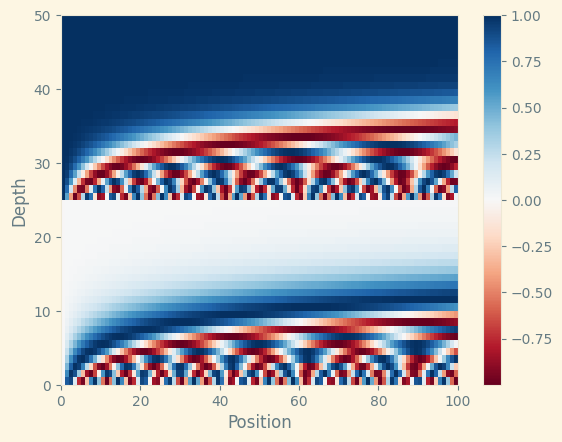

In [109]:




# pos_encoding = tf.cast(pos_encoding, dtype=tf.float32).numpy().T
# plt.pcolormesh(pos_encoding, cmap='RdBu')
# plt.ylabel('Depth')
# plt.xlabel('Position')
# plt.colorbar()
# plt.show()

# We add these positions to the embedding vector for each word

In [17]:
p = [[i for i in range(5)] for _ in range(5)]
pd.DataFrame(p)
# x=[]
# for i in p:
#     x = np.concatenate([i,x])
# x

,0,1,2,3,4
0,0,1,2,3,4
1,0,1,2,3,4
2,0,1,2,3,4
3,0,1,2,3,4
4,0,1,2,3,4


In [ ]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)